In [1]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

New for multiple images in CP file

In [2]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-08-08 RZ hTERT DMSO"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


                                        FileName_RGB  ImageNumber
0  2024-07-30 RZ RD Belskaya GA-701 UV 0H (Multic...            1
1  2024-07-30 RZ RD Belskaya GA-701 UV 3H (Multic...            2
2  2024-07-30 RZ RD Belskaya GA-701 dark 0H (Mult...            3
3  2024-07-30 RZ RD Belskaya GA-701 dark 3H (Mult...            4
4  2024-08-02 RZ RD Belskaya GA-701 preUV 0H (Mul...            5
5  2024-08-02 RZ RD Belskaya GA-701 preUV 3H (Mul...            6
6  2024-08-02 RZ RD Belskaya GA-705 preUV 0H (Mul...            7
7  2024-08-02 RZ RD Belskaya GA-705 preUV 3H (Mul...            8


Extract wellmaps and combine into one df with names of the images

C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-30 RZ RD Belskaya GA-701 GA-705\2024-07-30 RZ RD Belskaya GA-701 dark 0H (Multichannel).toml


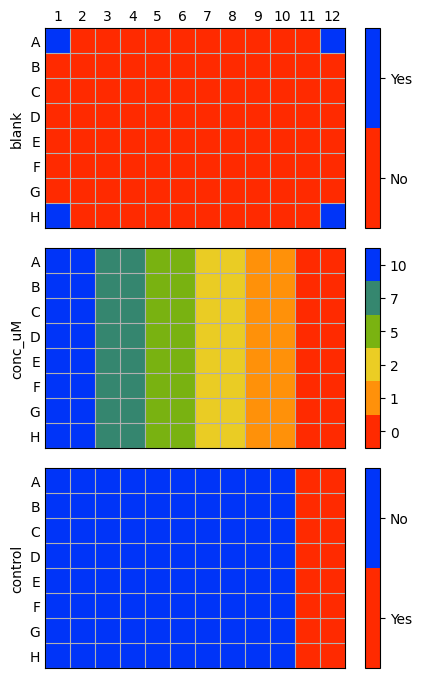

In [3]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

Generating labels for wells

In [4]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

    row  col
0     A    1
1     B    1
2     C    1
3     D    1
4     E    1
..   ..  ...
763   D   12
764   E   12
765   F   12
766   G   12
767   H   12

[768 rows x 2 columns]


Add images names to data (thank you CellProfiler for convenience)

Percents

In [5]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_pc"]] = data_plate[["conc_pc"]].apply(pd.to_numeric)

print(data_plate)

KeyError: "None of [Index(['conc_pc'], dtype='object')] are in the [columns]"

Micromoles

In [6]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_uM"]] = data_plate[["conc_uM"]].apply(pd.to_numeric)

print(data_plate.columns)
print(data_plate['sample'].unique())

Index(['row', 'col', 'ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed',
       'FileName_RGB', 'well', 'well0', 'row_i', 'col_j', 'blank', 'conc_uM',
       'cells', 'RZ_incubation', 'substance_incubation', 'culture_type',
       'control', 'sample'],
      dtype='object')
['GA-701 UV' 'GA-701 dark' 'GA-701 preUV' 'GA-705 preUV']


In [7]:
sample_list = data_plate['sample'].unique()

data_plate_corrected = data_plate.iloc[:0,:].copy()  #Clone of plates df but empty

print(sample_list)

# sample_plate_list = []

# sample_list_test = ['GA-702']

for sample in sample_list:
    data_plate_i = data_plate[(data_plate['sample'] == sample)]
    reference_plate = data_plate_i[(data_plate_i['RZ_incubation'] == '0H')]
    sample_plate = data_plate_i[(data_plate_i['RZ_incubation'] != '0H')]

    reference_plate = reference_plate.reset_index(drop=True)
    sample_plate = sample_plate.reset_index(drop=True)

    mean = reference_plate['Intensity_IntegratedIntensity_OrigGreen'].mean()
    
    reference_plate['Mean_dif'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/mean

    sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 


    data_plate_corrected = data_plate_corrected.append(sample_plate)



['GA-701 UV' 'GA-701 dark' 'GA-701 preUV' 'GA-705 preUV']


C:\Users\Modern\AppData\Local\Temp\ipykernel_19364\1412442439.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)
C:\Users\Modern\AppData\Local\Temp\ipykernel_19364\1412442439.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)
C:\Users\Modern\AppData\Local\Temp\ipykernel_19364\1412442439.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)
C:\Users\Modern\AppData\Local\Temp\ipykernel_19364\1412442439.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 14.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 10.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


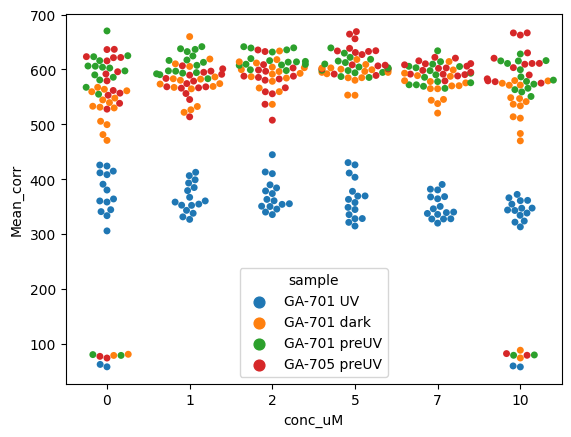

In [11]:
ay = sns.swarmplot(data=data_plate_corrected, x="conc_uM", y="Mean_corr", hue = 'sample')

In [12]:
blank_array = []

plate_list = data_plate_corrected['FileName_RGB'].unique()
print(plate_list)

for p in plate_list:
    blank_p = data_plate_corrected[(data_plate_corrected['blank'] == 'Yes') & 
                                   (data_plate_corrected['FileName_RGB'] == p)].loc[:,'Mean_corr'].mean()
    
    blank_std_p = data_plate_corrected[(data_plate_corrected['blank'] == 'Yes') 
                                       & (data_plate_corrected['FileName_RGB'] == p)].loc[:,'Mean_corr'].std()

    bc_array_i = [blank_p, blank_std_p ,p]

    print(bc_array_i)

    blank_array.append(bc_array_i)

    blank_df = pd.DataFrame(blank_array, columns = ['blank_mean','blank_std','FileName_RGB']) 

data_plate_with_blank_values = pd.merge(data_plate_corrected, blank_df, on=['FileName_RGB'])



['2024-07-30 RZ RD Belskaya GA-701 UV 3H (Multichannel).tif'
 '2024-07-30 RZ RD Belskaya GA-701 dark 3H (Multichannel).tif'
 '2024-08-02 RZ RD Belskaya GA-701 preUV 3H (Multichannel).tif'
 '2024-08-02 RZ RD Belskaya GA-705 preUV 3H (Multichannel).tif']
[59.473529028080094, 2.126909376144324, '2024-07-30 RZ RD Belskaya GA-701 UV 3H (Multichannel).tif']
[80.52194852869714, 5.874351292828071, '2024-07-30 RZ RD Belskaya GA-701 dark 3H (Multichannel).tif']
[79.45342730677437, 0.6666752606844109, '2024-08-02 RZ RD Belskaya GA-701 preUV 3H (Multichannel).tif']
[78.08321479309278, 3.399615890919454, '2024-08-02 RZ RD Belskaya GA-705 preUV 3H (Multichannel).tif']


In [13]:
data_plate_with_blank_values['Green_blanked'] = data_plate_with_blank_values['Mean_corr'] - data_plate_with_blank_values['blank_mean']

data_plate_wo_blank = data_plate_with_blank_values[data_plate_with_blank_values.blank == 'No'].copy() #dataframe without blank

control_array = []

for p in plate_list:
    control_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') & 
                                    (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].mean()

    control_std_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') & 
                                        (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].std()
    

    ctr_array_i = [control_p, control_std_p ,p]


    control_array.append(ctr_array_i)

    control_df = pd.DataFrame(control_array, columns = ['control_mean','control_std','FileName_RGB']) 

print(control_df)

data_plate_with_control = pd.merge(data_plate_wo_blank, control_df, on=['FileName_RGB'])


   control_mean  control_std  \
0    316.464167    37.723017   
1    450.591469    30.907562   
2    522.747374    27.955774   
3    511.953290    37.286312   

                                        FileName_RGB  
0  2024-07-30 RZ RD Belskaya GA-701 UV 3H (Multic...  
1  2024-07-30 RZ RD Belskaya GA-701 dark 3H (Mult...  
2  2024-08-02 RZ RD Belskaya GA-701 preUV 3H (Mul...  
3  2024-08-02 RZ RD Belskaya GA-705 preUV 3H (Mul...  


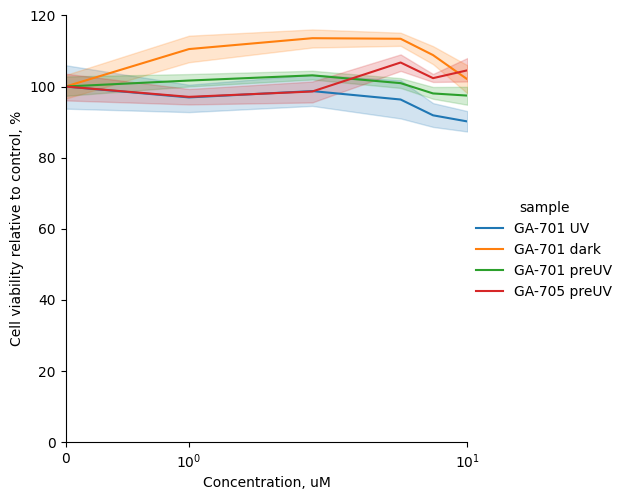

In [15]:
data_plate_with_control['Green_relative'] = data_plate_with_control['Green_blanked']/data_plate_with_control['control_mean']*100

ax = sns.relplot(data=data_plate_with_control, x="conc_uM", y="Green_relative", hue = 'sample',  kind="line")

ax.set(xscale="symlog")

ax.set(xlim=(0, 10),ylim = (0,120))

ax.set(xlabel='Concentration, uM', ylabel='Cell viability relative to control, %')

plt.show()




[(-1.0, 5.5), (0.0, 130.0)]

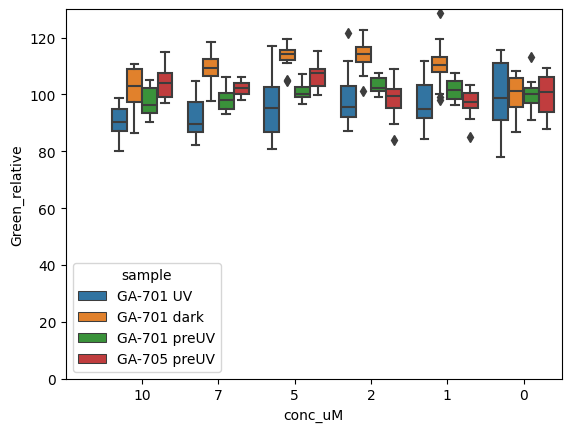

In [335]:
ax = sns.boxplot(data=data_plate_with_control, x="conc_uM", y="Green_relative", hue = 'sample')


ax.set(xlim=(-1, None),ylim = (0,130))

0H plate as a reference plate

In [ ]:
reference_plate = data_plate[(data_plate['RZ_incubation'] == '0H')].copy()

# print(reference_plate)

heatmap_df = reference_plate.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigGreen")

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

# print(reference_plate['Intensity_IntegratedIntensity_OrigGreen'])

In [ ]:
p = "2024-07-30 RZ RD Belskaya GA-702 dark 0H (Multichannel).tif"

mean = reference_plate[(reference_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

print(mean)

reference_plate['Mean_dif'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/mean

reference_plate['Mean_corr'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 

print(reference_plate['Mean_dif'])

heatmap_df = reference_plate.pivot(index="row", columns="col", values="Mean_dif")

sns.heatmap(heatmap_df, linewidth=.5, vmax=1.2, vmin=0.80 )


plt.show()


In [ ]:
sample_plate = data_plate[(data_plate['RZ_incubation'] == '24H')].copy().reset_index(drop=True)

heatmap_df = sample_plate.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigGreen")

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

print(sample_plate)

In [ ]:
sample_plate['Mean_dif'] = reference_plate['Mean_dif']

sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']*sample_plate['Mean_dif']

print(sample_plate['Mean_corr'])

heatmap_df = sample_plate.pivot(index="row", columns="col", values="Mean_corr")

# sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

p = "2024-07-29 RZ hTERT SPH Slovesnova 0H (Multichannel).tif"

mean_sample = sample_plate[(sample_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

sample_plate['Mean_dif_to_mean'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/mean_sample

sample_plate['Mean_dif_to_mean'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/mean_sample

sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 

sample_plate['Mean_corr_dif'] = sample_plate['Mean_corr']/mean_sample


heatmap_df = sample_plate.pivot(index="row", columns="col", values="Mean_corr")

sns.heatmap(heatmap_df, linewidth=.5 )


plt.show()


In [ ]:
# row_drop_list = ['A','H']

# cleared_data = sample_plate[~sample_plate['row'].isin(row_drop_list)]

cleared_data = sample_plate[sample_plate['blank']=='No']

well_drop_list = ['']

ax = sns.boxplot(data=cleared_data, x="conc_pc", y="Intensity_MeanIntensity_OrigGreen", hue = 'substance', palette=['r'])

ay = sns.boxplot(data=cleared_data, x="conc_pc", y="Mean_corr", hue = 'substance')

In [ ]:
# row_drop_list = ['A','H']

# cleared_data = sample_plate[~sample_plate['row'].isin(row_drop_list)]

cleared_data = sample_plate[sample_plate['blank']=='No']

well_drop_list = ['']

ax = sns.boxplot(data=cleared_data, x="sample", y="Intensity_MeanIntensity_OrigGreen", palette=['r'])

ay = sns.boxplot(data=cleared_data, x="sample", y="Mean_corr")

In [ ]:

# ax = sns.relplot(data=cleared_data, x="conc_pc", y="Intensity_MeanIntensity_OrigGreen", hue = 'substance', palette=['r'],  kind="line")

ay = sns.relplot(data=cleared_data, x="sample", y="Mean_corr", hue = 'substance',  kind="line")
# ay = sns.stripplot(data=cleared_data, x="conc_pc", y="Mean_corr", hue = 'substance')

# ax.set(xscale="symlog")
# ay.set(xscale="symlog")

# ax.set(xlim=(0, 200))
# ay.set(xlim=(0, 200))

In [ ]:
ax = sns.swarmplot(data=cleared_data, x="sample", y="Intensity_MeanIntensity_OrigGreen", palette=['r'])

ay = sns.swarmplot(data=cleared_data, x="sample", y="Mean_corr")


Blank and control calculation for each plate

In [ ]:
blank_array = []

p = "2024-07-29 RZ hTERT SPH Slovesnova 24H (Multichannel).tif"



blank_p = sample_plate[(sample_plate['blank'] == 'Yes') & (sample_plate['FileName_RGB'] == p)].loc[:,'Mean_corr'].mean()
blank_std_p = sample_plate[(sample_plate['blank'] == 'Yes') & (sample_plate['FileName_RGB'] == p)].loc[:,'Mean_corr'].std()

bc_array_i = [blank_p, blank_std_p ,p]

blank_array.append(bc_array_i)

blank_df = pd.DataFrame(blank_array, columns = ['blank_mean','blank_std','FileName_RGB']) 

data_plate_with_blank = pd.merge(sample_plate, blank_df, on=['FileName_RGB'])



In [ ]:
data_plate_with_blank['Green_blanked'] = data_plate_with_blank['Mean_corr'] - data_plate_with_blank['blank_mean']


data_plate_wo_blank = data_plate_with_blank[data_plate_with_blank.blank == 'No'].copy() #dataframe without blank

control_array = []

control_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') 
                                & (data_plate_wo_blank['blank'] == 'No') & 
                                (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].mean()

control_std_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') 
                                    & (data_plate_wo_blank['blank'] == 'No') & 
                                    (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].std()

bc_array_i = [control_p,control_std_p,p]

control_array.append(bc_array_i)

control_df = pd.DataFrame(control_array, columns = ['control_mean', 'control_std','FileName_RGB']) 

print(control_df)

data_plate_with_control = pd.merge(data_plate_wo_blank, control_df, on=['FileName_RGB'])

data_plate_with_control['Green_relative'] = data_plate_with_control['Green_blanked']/data_plate_with_control['control_mean']*100


print(data_plate_with_control[(data_plate_with_control['control'] == 'Yes') 
                                & (data_plate_with_control['blank'] == 'No') & 
                                (data_plate_with_control['FileName_RGB'] == p)].loc[:,'Green_relative'])

Plotting


In [ ]:

# row_drop_list = ['A','H']

row_drop_list = []

cleared_data = data_plate_with_control[~data_plate_with_control['row'].isin(row_drop_list)]

ax = sns.relplot(data=cleared_data, x="conc_pc", y="Green_relative", kind="line", hue = 'substance')

# ax.set(xlabel=None, ylabel='Viable cell, % of control')

ax.set(xlabel='Concentration, pc', ylabel='Cell viability relative to control, %')
# ax.set(xscale="symlog")

# ax.set(xlim=(0, 200),ylim = (0,120))

# plt.show()



In [ ]:
ax = sns.boxplot(data=data_plate_with_control, x="sample", y="Green_relative")
ax.set(ylim = (0,None))